# “火炬上的深度学习"第一次大作业

在这个作业中，你需要半独立地利用人工神经网络搭建一个手写数字识别器

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第II课的配套源代码

In [1]:

"""简单的 LeNet-5类型的卷积神经网络模型，MNIST例子.
"""

#所有依赖包

import gzip
import os
import sys

import numpy as np
from six.moves import urllib
import torch
from torch.autograd import Variable
import torch.optim as optim

import matplotlib.pylab as plt

#定义一系列常数
SOURCE_URL = 'http://yann.lecun.com/exdb/mnist/' #图像数据如果没下载，可以从这个地址下载
WORK_DIRECTORY = 'data' #存储的路径名
IMAGE_SIZE = 28 #每张图片的大小尺寸
NUM_CHANNELS = 1  #每张图片的通道数
PIXEL_DEPTH = 255 #像素的深度0-255
NUM_LABELS = 10 #手写数字，一共十种

%matplotlib inline



# 读取MINST图形文件

In [26]:
#下载图像文件，如果文件已经存在，那么就不下载。
def maybe_download(filename):
    """Download the data from Yann's website, unless it's already here."""
    if not os.path.isdir(WORK_DIRECTORY):
        os.mkdir(WORK_DIRECTORY)
    filepath = os.path.join(WORK_DIRECTORY, filename)
    if not os.path.exists(filepath):
        filepath, _ = urllib.request.urlretrieve(SOURCE_URL + filename, filepath)
        size = os.path.getsize(filepath)
        print('Successfully downloaded', filename, size, 'bytes.')
    return filepath
# Get the data.
train_data_filename = maybe_download('train-images-idx3-ubyte.gz')
train_labels_filename = maybe_download('train-labels-idx1-ubyte.gz')
test_data_filename = maybe_download('t10k-images-idx3-ubyte.gz')
test_labels_filename = maybe_download('t10k-labels-idx1-ubyte.gz')

def extract_data(filename, num_images):
    # filename: 文件存放的路径，num_images: 读入的图片个数
    """将图像解压缩展开，读入成一个4维的张量： [image index（图像的编码）, y（纵坐标）, x（横坐标）, channels（通道）].
    我们将数组中的数值范围从原来的[0, 255]降低到了[-0.5, 0.5]范围内
    """
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(IMAGE_SIZE * IMAGE_SIZE * num_images * NUM_CHANNELS)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = (data - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
        data = data.reshape(num_images, NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
        return data

def extract_labels(filename, num_images):
    """将label的数据文件解压缩，并将label读成64位的整数"""
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

# 将数据解压缩并存储到数组中，60000张图片，60000个label，测试集中有10000张图片
train_data = extract_data(train_data_filename, 60000)
train_X = train_data.reshape(len(train_data), -1)
train_labels = extract_labels(train_labels_filename, 60000)
train_Y = train_labels
test_data = extract_data(test_data_filename, 10000)
test_X = test_data.reshape(len(test_data), -1)

test_labels = extract_labels(test_labels_filename, 10000)
test_Y = test_labels
train_X.shape, train_Y.shape

# train_X, train_Y 中分别存储的是向量化的训练数据与标签
# test_X, test_Y 中分别存储的是向量化的测试数据与标签
# train_X的维度是60000个样本，784个分量的图像向量
# test_X的维度是10000个样本，784个分量的图像向量

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


((60000, 784), (60000,))

In [27]:
train_X.size

train_Y.size

train_X.shape[1]

784

# 在这里写下你自己的代码

### 第一步：定义神经网络，提示，可以使用简单的torch.nn.SequentialModel

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第II课的配套源代码

In [43]:
# # 提示：需要考虑好网络有几层，每一层有多少个节点
# net = torch.nn.Sequential(
#    torch.nn.Linear(784, 10),
#    torch.nn.Sigmoid(),
# )

# # 问题：如果要增加新的神经网络层怎么办？

input_size = train_X.shape[1]
output_size = 1
hidden_size = 10
batch_size = 128

neuc = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden_size, output_size)
)


cost = torch.nn.MSELoss()
optimizer = torch.optim.SGD(neuc.parameters(), lr = 0.1)

### 第二步：构造损失函数和优化器

In [5]:
# cost = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(net.parameters(), lr = 0.1)

### 第三步：开始训练循环

In [55]:
# 提示：有两重循环，最外面层是多少次的训练，里层为对数据批次（batch）的循环


#神经网络训练循环
batch_size = 128
losses = []
for i in range(1000):
    #每128个样本点被划分为一个撮，在循环的时候一撮一撮地读取
   batch_loss = []
    #start和end分别是提取一个batch数据的起始和终止下标
   for start in range(0, len(train_X), batch_size):
    
    end = start + batch_size if start + batch_size < len(train_X) else len(train_X)
        
    xx = torch.tensor(train_X[start:end],dtype = torch.float, requires_grad = True)  #从训练数据train_X中提取数据
    yy = torch.tensor(train_Y[start:end],dtype = torch.float, requires_grad = True) #从训练数据train_Y中提取标签，注意标签数据为整数，因此相应的tensor也要为long

    predict = neuc(xx) #用神经网络进行预测
    loss = cost(predict, yy) 
    optimizer.zero_grad() #清空梯度
    loss.backward() #开始反向传播
    optimizer.step() #开始更新梯度
    batch_loss.append(loss.data.numpy())
    
    #每隔100步输出一下损失值（loss）
   if i % 100==0:
    losses.append(np.mean(batch_loss))
    print(i, np.mean(batch_loss))

0 8.354244
100 8.354126
200 8.354006
300 8.353887
400 8.353767
500 8.353653
600 8.353545
700 8.353442
800 8.353343
900 8.353246


### 请在这里写下你自己的回答

In [50]:
# 请绘制上面训练过程的损失函数曲线，以及'''错误率曲线'''！！！
batch_loss

[array(9.288532, dtype=float32),
 array(8.219566, dtype=float32),
 array(7.9849415, dtype=float32),
 array(8.781867, dtype=float32),
 array(8.587776, dtype=float32),
 array(7.8709464, dtype=float32),
 array(7.9780107, dtype=float32),
 array(7.8358192, dtype=float32),
 array(8.858924, dtype=float32),
 array(7.2436976, dtype=float32),
 array(8.990645, dtype=float32),
 array(7.881851, dtype=float32),
 array(7.85855, dtype=float32),
 array(8.67181, dtype=float32),
 array(8.238655, dtype=float32),
 array(7.606752, dtype=float32),
 array(7.945042, dtype=float32),
 array(6.5934677, dtype=float32),
 array(8.139976, dtype=float32),
 array(7.780422, dtype=float32),
 array(8.318783, dtype=float32),
 array(8.5035715, dtype=float32),
 array(7.3489113, dtype=float32),
 array(8.898722, dtype=float32),
 array(8.550892, dtype=float32),
 array(8.392812, dtype=float32),
 array(8.218269, dtype=float32),
 array(8.886884, dtype=float32),
 array(8.479437, dtype=float32),
 array(8.550064, dtype=float32),
 arr

Text(0,0.5,'MSE')

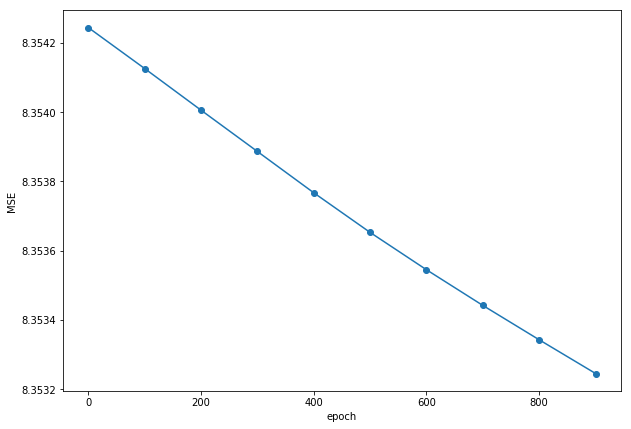

In [56]:
# 打印输出损失值
fig = plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(losses))*100,losses, 'o-')
plt.xlabel('epoch')
plt.ylabel('MSE')

Text(0,0.5,'MSE')

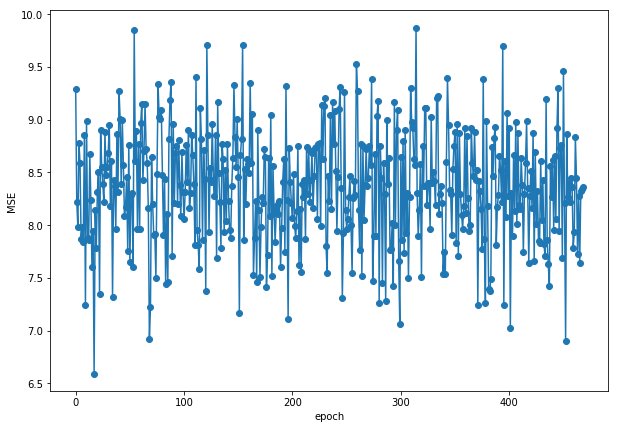

In [53]:
fig = plt.figure(figsize = (10,7))
plt.plot(np.arange(len(batch_loss)), batch_loss, 'o-')
plt.xlabel('epoch')
plt.ylabel('MSE')

### 第四步：在测试集上测试模型

In [65]:
# 定义一个专门计算分类错误率的函数，它的基本思想是，对于预测向量predictions的每一行，
# 取最大的那个元素的下标，与标签labels中的元素做比较
def error_rate(predictions, labels):
   """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，labels是数据之中的正确答案"""
   predictions = np.argmax(predictions, 1)
   return 100.0 - (
     100.0 *
     np.sum( predictions == labels) /
     predictions.shape[0])

In [67]:
# 分多个batch计算测试结果
errors = []
losses = []
i = 0
for start in range(0, len(test_X), batch_size):
   end = start + batch_size if start + batch_size < len(test_X) else len(test_X)
   i += 1
   x = torch.tensor(test_X[start:end], dtype = torch.float, requires_grad = True)
   y = torch.tensor(test_Y[start:end], dtype = torch.float, requires_grad = True)
   predictions = neuc(x)
   loss = cost(predictions, y)
   err_rate = error_rate(predictions.data.numpy(), y.data.numpy())
   errors.append(err_rate)
   losses.append(loss.data.numpy())
   print(i, err_rate)

print('平均错误率：%.4f%%'%np.mean(errors))

1 92.1875
2 92.96875
3 89.0625
4 92.96875
5 89.0625
6 89.84375
7 92.96875
8 92.96875
9 94.53125
10 88.28125
11 93.75
12 88.28125
13 91.40625
14 88.28125
15 90.625
16 93.75
17 92.96875
18 91.40625
19 89.0625
20 90.625
21 89.0625
22 87.5
23 92.1875
24 89.0625
25 92.96875
26 85.9375
27 89.0625
28 92.96875
29 88.28125
30 90.625
31 90.625
32 87.5
33 93.75
34 90.625
35 88.28125
36 94.53125
37 90.625
38 90.625
39 92.96875
40 89.0625
41 92.1875
42 85.15625
43 89.84375
44 89.84375
45 88.28125
46 90.625
47 87.5
48 89.0625
49 92.96875
50 89.84375
51 88.28125
52 89.0625
53 90.625
54 90.625
55 88.28125
56 90.625
57 88.28125
58 91.40625
59 89.84375
60 90.625
61 89.84375
62 85.9375
63 89.84375
64 89.84375
65 89.84375
66 89.84375
67 89.0625
68 89.84375
69 89.84375
70 89.84375
71 89.84375
72 91.40625
73 87.5
74 88.28125
75 92.96875
76 87.5
77 90.625
78 89.0625
79 93.75
平均错误率：90.2393%


### 用单个图像进行测试

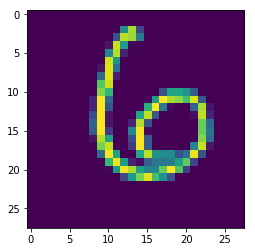

In [79]:
#随便从数据集中读入一张图片，并绘制出来
idx = 100
muteimg = test_data[idx, 0, :, :]
plt.imshow(muteimg)

In [80]:
# 计算识别结果
x = torch.tensor(test_X[idx, :].reshape(1,-1), dtype = torch.float, requires_grad = True)
predict = neuc(x)
np.argmax(predict.data.numpy())

0

## 升级版

如果你已经运行跑通上面的所有代码，那么请你尝试对其进行更改，让测试集上面的识别错误率进一步下降，看看能不能到1%以下

提示：可以考虑增加层的深度

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第II课的配套源代码